# How much should properties be worth in Milwaukee, Wisconsin? (Part I)

## Goals (3 min)
The famous statistician George E.P. Box once stated:

$$
\textbf{"All models are wrong, but some models are useful."}
$$

Our world behaves according to so many variables which are out of our control, that expecting a simple model to *perfectly* explain these nuances is impossible. However, we can try to mitigate this issue by improving our understanding on the errors our models are producing. This allows us to update the model accordingly and be able to enhance its usefulness.

The main goal is of this case is to learn how to conduct a proper analysis of the errors (residuals) of linear regression models and how to use this analysis to make improvements in the model. You will see again how variable transformations and a study of outliers in the residuals can help with this task.

In [2]:
### Load relevant packages
import pandas                  as pd
import numpy                   as np
import matplotlib.pyplot       as plt
import seaborn                 as sns
import statsmodels.formula.api as smf
import statsmodels.api         as sm
import scipy

%matplotlib inline
plt.style.use('ggplot')
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

C:\Users\silve\Miniconda3\envs\DS4A-Env\lib\site-packages\statsmodels\compat\pandas.py:23: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


## Introduction (5 min)

**Business Context.** Real estate markets can sometimes be irrational, and buying a house can certainly be an emotional and highly psychological process. For example, the asking price can [“anchor”](https://en.wikipedia.org/wiki/Anchoring) the negotiations, and it can be very hard as a buyer to “forget” that initial number.

You are a property developer who frequently buys properties. It would be very useful to get a fair estimate of the price of a property before seeing the asking price, based on features like its size and location. Besides making you a more informed buyer, having a pricing model could have multiple uses, such as automatically detecting under-priced properties that come on the market, or estimating the value added to a property if it was extended, divided into apartments, or converted into offices.

**Business Problem.** Your task is to **build a model to predict property prices in the city of Milwaukee, Wisconsin**.

**Analytical Context.** The dataset consists of property sales (commercial and residential) in Milwaukee, Wisconsin from 2002 to 2018. Linear regression is a simple idea: At the end of the day, we are just fitting a line through data. But its simplicity is also its strength: coefficients are easily interpretable and it is straightforward to understand the underlying model. However, many things can go wrong during the process of fitting a linear model.

The case is structured as follows: you will 1) explore the data to pick up on some initial patterns; 2) analyze **residuals**, the difference between the actual values and their estimates, to diagnose an initial model; 3) perform variable transformations to partially deal with problems; and finally 4) look at how to deal with outliers to improve the model further.

## Data exploration (25 min)

Let's start by taking a look at the available features:

1. **PropType**: the property category (“Commercial”, “Residential”, “Lg Apartment”, “Vacant Land”, or “Condominium”)
2. **Taxkey**: a unique identifier for the property
3. **Address**: the street address of the property
4. **CondoProject**: for condominiums, the name of the project
5. **District**: integer between 1 and 15 identifying the city district
6. **Nbhd**: integer identifying one of 591 neighborhoods
7. **Style**: information about the building architectural style, commerical use or type of building
8. **Extwall**: type of exterior wall (e.g. “Brick”)
9. **Stories**: number of stories
10. **Year_Built**: the year the building was built
11. **Nr_of_rms**: number of rooms
12. **Fin_sqft**: finished square feet
13. **Units**: number of units (e.g. apartments) in the building
14. **Bdrms**: number of bedrooms
15. **Fbath**: number of full bathrooms
16. **Hbath**: number of half bathrooms
17. **Lotsize**: size of the lot in square feet
18. **Sale_date**: the date of the sale in YYYY-MM-DD format
19. **Sale_price**: sale price in US dollars

In [3]:
data = pd.read_csv("2002-2018-property-sales-data.csv",
    dtype = { # indicate categorical variables
        "PropType": "category",
        "District": "category",
        "Extwall": "category",
        "Nbhd": "category",
        "Style": "category",
    },
    parse_dates=["Sale_date"], # the Sale_date column is parsed as a date
)
data.head()

,PropType,Taxkey,Address,CondoProject,District,Nbhd,Style,Extwall,Stories,Year_Built,Nr_of_rms,Fin_sqft,Units,Bdrms,Fbath,Hbath,Lotsize,Sale_date,Sale_price
0,Commercial,3230461110,2628 N 6TH ST,NaN,6,6258,Commercial Exempt,NaN,2.0,1880,0,1840,1,0,0,0,12750,2002-01-01,15900
1,Commercial,3590192000,1363 N PROSPECT AV,NaN,3,6262,Mansions With Commercial Usage,NaN,2.0,1876,0,6377,1,0,0,0,11840,2002-01-01,850000
2,Commercial,4161194000,617 S 94TH ST,NaN,10,6272,Service Building,NaN,1.0,1954,0,5022,1,0,0,0,9700,2002-01-01,119000
3,Commercial,1719836000,3624 W SILVER SPRING DR,NaN,1,6218,"Store Bldg - Multi Story (Store & Apt, Store & O",NaN,2.0,1955,0,6420,1,0,0,0,8792,2002-01-01,210000
4,Commercial,3480290000,3830 W LISBON AV,NaN,15,6254,"Store Bldg - Multi Story (Store & Apt, Store & O",NaN,2.0,1909,0,5956,1,0,0,0,4840,2002-01-01,48500


In [4]:
data.shape
data.isnull().sum()

PropType            3
Taxkey              0
Address             0
CondoProject    27867
District            0
Nbhd                0
Style               6
Extwall          9899
Stories             0
Year_Built          0
Nr_of_rms           0
Fin_sqft            0
Units               0
Bdrms               0
Fbath               0
Hbath               0
Lotsize             0
Sale_date           0
Sale_price          0
dtype: int64

Sometimes missing numbers are entered as zeros, which can mess up the analysis (see `Lotsize` below as an example). 
Before proceeding, we will remove rows with zeros in `Year_Built`, `Fin_sqft`, `Lotsize`, and `Sale_price`, as these are the numerical variables where erroneous zero values can skew the distribution:

Text(0, 0.5, 'count')

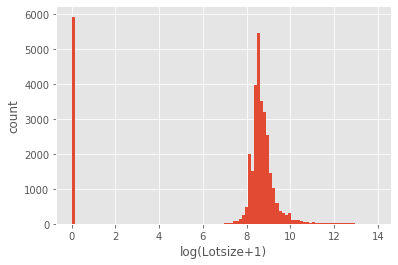

In [5]:
plt.hist(np.log(data["Lotsize"]+1), bins=100)
plt.xlabel("log(Lotsize+1)")
plt.ylabel("count")

For the sake of removing potential confounding factors from consideration, we will focus on residential properties only (commercial properties are subject to all sorts of economic and market forces that residential properties are not):

In [6]:
def remove_unused_categories(data):
    """ The `remove_unused_categories` method in pandas
        removes categories from a Series if there are no
        elements of that category.
        
        This function is a convenience function that removes
        unused categories for all categorical columns
        of a data frame.
        
        The reason this is useful is that when we
        fit a linear regression, `statsmodels` will
        create a coefficient for every category in a column,
        and so unused categories pollute the results.
    """
    for cname in data:
        col = data[cname]
        if pd.api.types.is_categorical_dtype(col):
            data[cname] = col.cat.remove_unused_categories()
    return data

clean = np.where(
    (data["Sale_price"] > 0) & 
    (data["Year_Built"] > 1800) &
    (data["Fin_sqft"] > 0) & # must have non-zero finished square feet
    (data["Lotsize"] > 0)  & # must have non-zero lot size
    (data["PropType"] == "Residential")
    )
data_clean = data.iloc[clean].copy()
remove_unused_categories(data_clean).head()

,PropType,Taxkey,Address,CondoProject,District,Nbhd,Style,Extwall,Stories,Year_Built,Nr_of_rms,Fin_sqft,Units,Bdrms,Fbath,Hbath,Lotsize,Sale_date,Sale_price
10,Residential,3080013000,3033 N 35TH ST,NaN,7,2960,AP 1,Frame,2.0,1913,0,3476,4,9,1,0,5040,2002-02-01,42000
51,Residential,3190434000,1908 E WEBSTER PL,NaN,3,3170,Rm or Rooming House,Frame,2.0,1897,0,1992,4,2,2,0,2880,2002-05-01,145000
67,Residential,3891722000,812 N 25TH ST,NaN,4,3040,Rm or Rooming House,Frame,2.0,1907,0,2339,6,0,1,0,3185,2002-06-01,30000
116,Residential,3880628000,959 N 34TH ST,NaN,4,2300,AP 1,Frame,2.0,1890,0,2329,4,4,1,0,5781,2002-10-01,66500
134,Residential,3880406000,3209 W WELLS ST,NaN,4,2300,Mansion,Stone,2.5,1891,0,7450,2,7,6,0,15600,2002-11-01,150500


In [7]:
data_clean.shape

(24450, 19)

### Exercise 1: (15 min)

#### 1.1

Write code to visualize the relationship between the logarithm of the sale price per square foot (`Fin_sqft`) and the following variables:
 
1. the number of units (C)
2. the year the building was built 
3. the city district (C)
4. the logarithm of the finished square footage
5. the number of bedrooms (C)
6. the sale date

For categorical variables, it can be helpful to use **violin plots**, which first separates the data by category and then shows the distribution of the $y$ variable as a smooth histogram for each category. 

**Hint:** You can use the seaborn function ```sns.violinplot(x,y,data)```. For this exercise, draw violin plots for the variables with a (C) as shown above.

**Answer.** One possible solution is shown below:

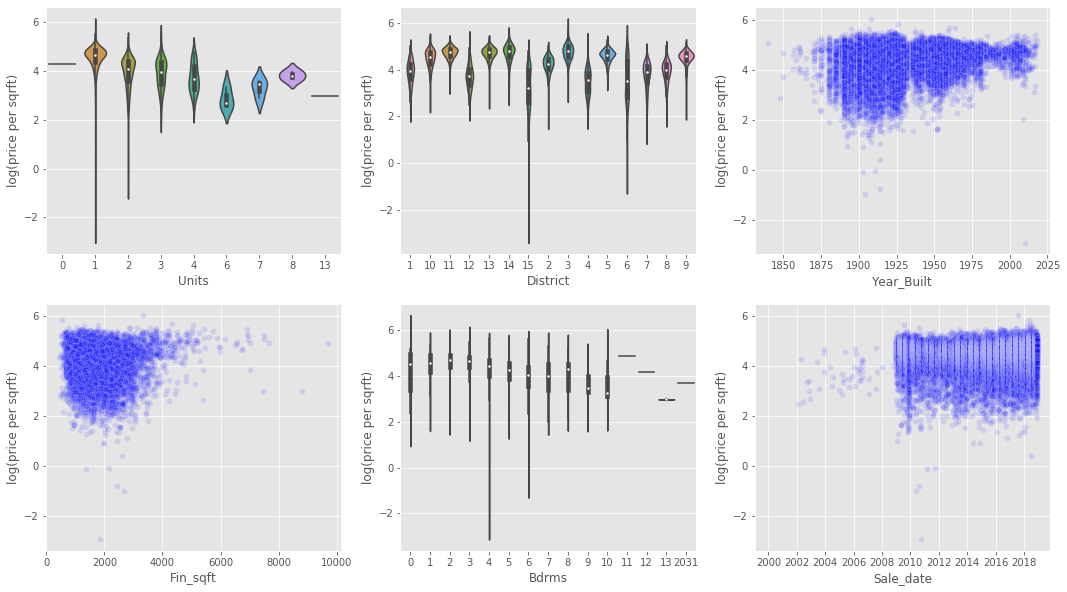

In [8]:
varstolook = ["Units", "District", "Year_Built", "Fin_sqft", "Bdrms", "Sale_date"]
data_clean2=data_clean.copy()
data_clean2['log(price per sqrft)']=np.log(data_clean["Sale_price"] / data_clean["Fin_sqft"])

plt.figure(figsize=(18,10))
for i,var in enumerate(varstolook):
    plt.subplot(2,3,i+1)
    if var in ['Units','District','Bdrms']:
        sns.violinplot(x=var, y='log(price per sqrft)', data=data_clean2)
    else:
        sns.scatterplot(x=var,y='log(price per sqrft)',data=data_clean2, alpha=0.10,color='b')
        

#### 1.2

What can you conclude from these exploratory plots? Select all that apply.

(a) Properties built in the last ten years tend to be more valuable (per square foot)

(b) Dividing a single-unit property into smaller units would tend to make it more valuable

(c) Many of the most valuable properties are in districts 3 and 14

(d) Having more bedrooms makes a property less valuable

**Answer.**

(a) False. Some of the most valuable properties (but also some of the *least* valuable properties are older. There is no clearly discernible trend.

(b) False. While this may be true, it cannot be seen in these  plots alone. In fact the plots show that properties with more units are typically *less* valuable per square foot than single-unit properties. It may be reasonable to infer that the residents of Milwaukee have a marked preference for living in their own houses. But single-unit and multi-unit properties differ in other ways (for example they may be concentrated in different neighborhoods), which makes it impossible to draw solid conclusions from this plot alone.

(c) True. Indeed the upper tails of the violin plot for districts 3 and 14 extend further than the other districts. So those districts have some of the most valuable properties, at least on a per-square-foot basis. A quick look at a [map](https://city.milwaukee.gov/ImageLibrary/Groups/electionAuthors/howtorun/maps/newdistrictmap2012.jpg) of the districts shows that these are both near Lake Michigan and a short distance from the central business district (District 4).

(d) False. While this may appear to be true from the plot, it is reasonable to suspect that properties with many bedrooms are larger and have multiple units, which *confounds* the trend seen here.

### Exercise 2: (5 min)

Provide the code to fit a multiple linear regression of the sale price against the district, number of units, and finished square footage. Which districts does the model recognize as having the most valuable properties? Are all the coefficients significant? If not, how should we interpret the coefficients with high $p$-value?

**Answer.** One possible solution is shown below:

In [9]:
model_lin = smf.ols(formula = "Sale_price ~ District + Units+ Fin_sqft", 
                 data = data_clean).fit()
model_lin.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Sale_price   R-squared:                       0.675
Model:                            OLS   Adj. R-squared:                  0.674
Method:                 Least Squares   F-statistic:                     3165.
Date:                Sun, 22 Mar 2020   Prob (F-statistic):               0.00
Time:                        10:11:48   Log-Likelihood:            -2.9839e+05
No. Observations:               24450   AIC:                         5.968e+05
Df Residuals:                   24433   BIC:                         5.969e+05
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       2.148e+04   1775.106     12.098      0.000     1.8e+04     2.5e+04
District[T.10]  5.036e+04   1784.909     28.212      0.000    4.69e+04    5.39e+04
District[T.11]  7.328e+04   1718.694     42.637      0.000    6.99e+04    7.66e+04
District[T.12] -3335.9809   2778.758     -1.201      0.230   -8782.516    2110.554
District[T.13]  7.137e+04   1779.286     40.111      0.000    6.79e+04    7.49e+04
District[T.14]  8.839e+04   1776.422     49.758      0.000    8.49e+04    9.19e+04
District[T.15] -4.969e+04   2628.207    -18.906      0.000   -5.48e+04   -4.45e+04
District[T.2]    1.94e+04   1992.257      9.738      0.000    1.55e+04    2.33e+04
District[T.3]   1.382e+05   2042.091     67.692      0.000    1.34e+05    1.42e+05
District[T.4]  -6.223e+04   4101.571    -15.173      0.000   -7.03e+04   -5.42e+04
District[T.5]   5.588e+04   1715.179     32.582      0.000    5.25e+04    5.92e+04
District[T.6]  -6433.0661   2411.944     -2.667      0.008   -1.12e+04   -1705.509
District[T.7]  -1.445e+04   2145.136     -6.735      0.000   -1.87e+04   -1.02e+04
District[T.8]   -384.3202   2291.476     -0.168      0.867   -4875.753    4107.112
District[T.9]   4.308e+04   2088.960     20.622      0.000     3.9e+04    4.72e+04
Units          -6.983e+04    834.735    -83.660      0.000   -7.15e+04   -6.82e+04
Fin_sqft          98.4410      0.640    153.885      0.000      97.187      99.695
==============================================================================
Omnibus:                    16670.121   Durbin-Watson:                   1.740
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1483125.778
Skew:                           2.504   Prob(JB):                         0.00
Kurtosis:                      40.825   Cond. No.                     3.26e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.26e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The model recognizes Districts 3 and 14 as the ones having the more valuable properties. This agrees with our findings of Exercise 1. In addition, we see that the coefficients for Districts 12 and 8 are not significant. We conclude that there is no statistically significant difference between the prices of properties of Districts 1 and 8, and Districts 1 and 12, *once you take into account* the number of units and square footage of the properties.

## Inspecting residuals to diagnose a fitted model (30 min)

Linear regression is conceptually simple — after all, we are just fitting a line through our data — but a lot can go wrong. **Residual analysis** is an important tool for diagnosing many problems that can affect a linear regression.
The “residuals” are the difference between the observations $y$ and the corresponding fitted values $\hat{y}$;
visually it is the distance between the fitted line and the data points.

Residual analysis allows us to test some of the theoretical assumptions that underpin linear regression. The short version is that linear regression works best when the residuals are identically [normally distributed](https://en.wikipedia.org/wiki/Normal_distribution). You may have come across statements before claiming that “linear regression assumes the data are normally distributed", which is not entirely correct. Linear regression can still be a useful and powerful (and theoretically justified!) tool even if the data deviates from this assumption. That said, a distribution with fat tails is a particular problem for linear regression, because points “in the tails” that are far away from their fitted values can disproportionately affect the fitted coefficients and the predictions. Even a single such point, which could for example be caused by a misplaced decimal point when the raw data was manually entered into a spreadsheet by a distracted employee, can wreak havoc on a model. Such a data point is said to have high **leverage** on the model.

### Exercise 3: (15 min)

#### 3.1

Obtain the residuals by comparing observations against fitted values (`model_lin.fittedvalues`). Check that you recover the same values as those stored in `model_lin.resid`.

**Answer.** Statistical software conveniently computes a lot of things for us. But when learning a new tool, it is helpful to check that we understand where these numbers come from. This is a small example of this principle, where we make sure we know how to compute residuals, even though they are also directly available as an attribute of the model object. Note that in turn, the fitted values could have been “manually” obtained as `model_lin.predict(data_clean)`.

In [10]:
my_resid = data_clean.Sale_price - model_lin.fittedvalues
# check that the differences between my residuals and the 
# precomputed ones are all zero (within numerical rounding error):
np.allclose(my_resid, model_lin.resid) # should return True

True

#### 3.2

Plot a histogram and a QQ plot of the residuals. What do you notice? 
    
**Hint:** To compare the residuals histogram to a normal distribution, use the ```density=True``` argument of ```plt.hist```, which puts the histogram on the same scale as the normal distribution. Then, add the code:
```
xx = np.linspace(model_lin.resid.min(), model_lin.resid.max(), num=1000)
plt.plot(xx, scipy.stats.norm.pdf(xx, loc=0.0, scale=np.sqrt(model_lin.scale)),
    label="normal distribution")
```
to overlay the probability density function of the normal distribution.

In order visualize the outliers in the histogram, we can use the `rugplot()` function in the `seaborn` library. For the purpose of this exercise, define the outliers as those residuals which are more than four standard deviations away from zero.

**Answer.**  Here is one possible answer.

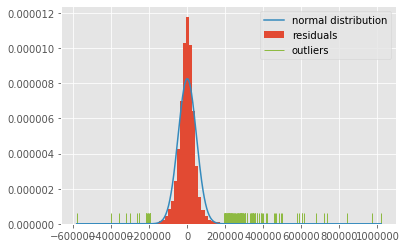

In [11]:
plt.hist(model_lin.resid, 
    density=True,     # the histogram integrates to 1 
                      # (so it can be compared to the normal distribution)
    bins=100,         #  draw a histogram with 100 bins of equal width
    label="residuals" # label for legend
    )
# now plot the normal distribution for comparison
xx = np.linspace(model_lin.resid.min(), model_lin.resid.max(), num=1000)
plt.plot(xx, scipy.stats.norm.pdf(xx, loc=0.0, scale=np.sqrt(model_lin.scale)),
    label="normal distribution")
outliers = np.abs(model_lin.resid)>4*np.sqrt(model_lin.scale)
sns.rugplot(model_lin.resid[outliers],
            color="C5", # otherwise the rugplot has the same color as the histogram
            label="outliers")
plt.legend(loc="upper right");

We immediately notice a few things:

1. The peak of the residuals is higher than the normal distribution
2. The bulk of the distribution of the residuals is narrower than the normal distribution
3. There are some large outliers on both sides
4. The residuals are not symmetrical; i.e. there are some particularly large outliers on the right side

**NOTE:** We are emphasizing visual diagnoses here, but there are metrics reported in the summary statistics table for the residuals that will tell the same story: the positive [skew](https://en.wikipedia.org/wiki/Skewness) and very high [kurtosis](https://en.wikipedia.org/wiki/Kurtosis) are causes for concern.

We also create the QQ plot of the residuals, which shows nonlinearity and is another strong warning sign:

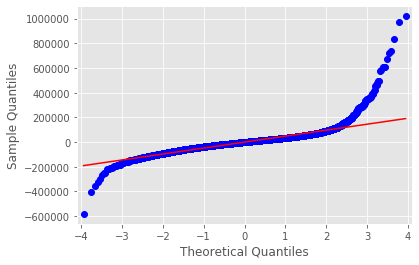

In [12]:
sm.qqplot(model_lin.resid, line="s");

Another troublesome situation that can be detected using residual analysis is **heteroscedasticity**, which means that the residuals have small variance for in some subsets of the data, and high variance in others. We saw this exactly early on in the previous case, with the data points "fanning out" around the line of best fit, and determined that this would cause problems. The opposite of heteroscedasticity is **homoscedasticity**, which is what we want to see in the data, and means that the residuals have similar variance across all subsets of the data.

### Exercise 4: (10 min)

#### 4.1

Suppose that we are given data from a pair houses in Milwaukee, say ```house1``` and ```house2```. We used our model to obtain a recommended sale price for  each house. The price returned for ```house1``` was $\$60,000$ and for ```house2``` was $\$7,000,000$. We know that the final selling price of each house will be different, as it depends on several other factors not included in the model. In the end, the actual selling price of each house will lie in some interval

$$
\begin{aligned}
 \$60,000-\verb*std1*&\leq \verb*house1* \leq \$60,000+\verb*std1*,\\
&\\
\$7,000,000-\verb*std2* &\leq \verb*house2*\leq \$7,000,000+\verb*std2*.
\end{aligned}
$$

Which deviation would you expect to be larger, ```std1``` or ```std2```?

**Answer.** We would expect ```std2``` to be much larger than ```std1```. Indeed, a buyer interested in a house around the $\$60k$ mark is probably a buyer that does not have a high income. Thus, he would be careful not to spend more than $\$10k$ or $\$20k$ over his budget. In contrast, a buyer of a house around the 7 million mark would probably have much larger flexibility in his budget. Thus, for them adding an extra cost of $\$500k$ or more may not matter much.

#### 4.2
Verify your findings from Exercise 4.1 by drawing a scatterplot of the residuals against the square footage. Are the residuals homoscedastic or heteroscedastic?

**Hint:** In order to see changes in the variance a little better, you may also subdivide the data in `Fin_sqft` into four bins and draw violin plots.

**Answer.** One possible solution is given below:

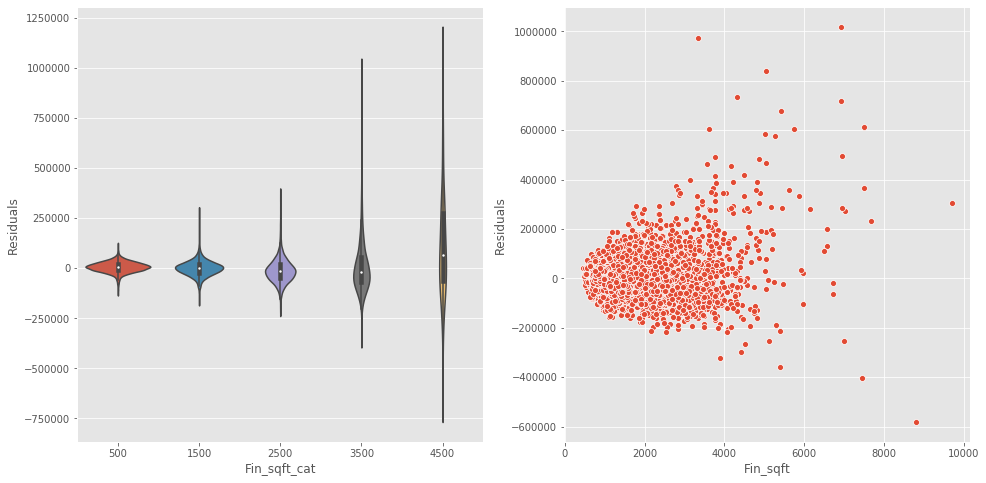

In [47]:
data_clean3=data_clean.copy()
bins = np.array([0, 1000, 2000, 3000, 4000])
data_clean3['Fin_sqft_cat']=bins[np.digitize(data_clean3['Fin_sqft'], bins)-1]+500
data_clean3['Residuals']=model_lin.resid.values

fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(16,8))

sns.violinplot(x='Fin_sqft_cat', y='Residuals',data=data_clean3,
               positions=(500, 1500, 2500, 3500, 4500),
               widths=700,
               showextrema=True, ax=ax[0],alpha=0.02
               )
sns.scatterplot(x='Fin_sqft',y='Residuals',data=data_clean3,ax=ax[1])

We can also overlay the violin plot on top of the scatterplot as follows:

Text(0, 0.5, 'residuals')

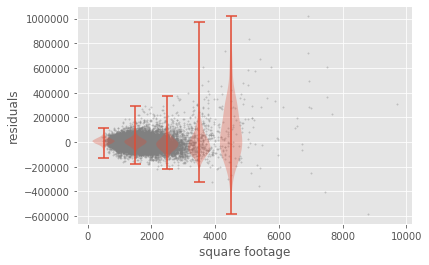

In [13]:
Fin_sqft = data_clean["Fin_sqft"]
# scatter plot of the residuals:
plt.scatter(Fin_sqft, model_lin.resid, s=2, alpha=0.3, color="grey")
# violin plot of the same data, divided into 5 bins:
bins = np.array([0, 1000, 2000, 3000, 4000])
sqft_bin = np.digitize(Fin_sqft, bins)
plt.violinplot([model_lin.resid.values[sqft_bin == ibin] for ibin in range(1,len(bins)+1)],
               positions=[500, 1500, 2500, 3500, 4500],
               widths=700,
               showextrema=True,
               )
plt.xlabel("square footage")
plt.ylabel("residuals")

The violin plots show that the residuals get wider as the properties get larger, which demonstrates heteroscedasticity.

As a side note, heteroscedasticity is easy to show, but homoscedasticity is hard to demonstrate, because we have to show that *none* of the variables exhibit heteroscedasticity. In general, use your *intuition* to hunt for heteroscedasticity; here, it was perhaps foreseeable that small (and hence cheap) houses would have a more predictable sales price than large (expensive) houses.

## Transforming variables to mitigate residuals issues (30 min)

Now that we have seen that the residuals are problematic, we need to figure out what to do about them. One possible solution is to borrow the technique we learned in a previous case – taking a transformation of the response variable. Let's try making the response variable the logarithm of `Sale_price`. It is a natural assumption that the sale price should be proportional to the square footage of the property. Therefore, we will also take the logarithm of the square footage as a predictor variable in this model:

In [14]:
model_log = smf.ols(formula = "np.log(Sale_price) ~ District + Units"
                           "+ np.log(Fin_sqft)", 
                 data = data_clean).fit()
model_log.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     np.log(Sale_price)   R-squared:                       0.599
Model:                            OLS   Adj. R-squared:                  0.599
Method:                 Least Squares   F-statistic:                     2283.
Date:                Sun, 22 Mar 2020   Prob (F-statistic):               0.00
Time:                        10:11:49   Log-Likelihood:                -10020.
No. Observations:               24450   AIC:                         2.007e+04
Df Residuals:                   24433   BIC:                         2.021e+04
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            5.2346      0.057     91.435      0.000       5.122       5.347
District[T.10]       0.6272      0.013     46.510      0.000       0.601       0.654
District[T.11]       0.8221      0.013     63.362      0.000       0.797       0.847
District[T.12]      -0.0038      0.021     -0.183      0.854      -0.045       0.037
District[T.13]       0.8019      0.013     59.694      0.000       0.776       0.828
District[T.14]       0.8701      0.013     64.855      0.000       0.844       0.896
District[T.15]      -0.4857      0.020    -24.462      0.000      -0.525      -0.447
District[T.2]        0.3132      0.015     20.827      0.000       0.284       0.343
District[T.3]        1.0223      0.015     66.953      0.000       0.992       1.052
District[T.4]       -0.1997      0.031     -6.464      0.000      -0.260      -0.139
District[T.5]        0.6896      0.013     53.242      0.000       0.664       0.715
District[T.6]       -0.1841      0.018    -10.103      0.000      -0.220      -0.148
District[T.7]       -0.0692      0.016     -4.272      0.000      -0.101      -0.037
District[T.8]        0.1567      0.017      9.050      0.000       0.123       0.191
District[T.9]        0.5799      0.016     36.764      0.000       0.549       0.611
Units               -0.3523      0.006    -55.450      0.000      -0.365      -0.340
np.log(Fin_sqft)     0.8687      0.008    104.173      0.000       0.852       0.885
==============================================================================
Omnibus:                     8475.447   Durbin-Watson:                   1.741
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           120216.866
Skew:                          -1.272   Prob(JB):                         0.00
Kurtosis:                      13.561   Cond. No.                         186.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Exercise 5: (15 min)

#### 5.1

Plot a histogram of the residuals, similar to what we did in Exercise 3. Did the log transformation fix the skewness and outlier issues that we noticed earlier?

**Hint:** What changes in [Skewness](https://en.wikipedia.org/wiki/Skewness) and [Kurtosis](https://en.wikipedia.org/wiki/Kurtosis)  do you see in the new model? 

**Answer.** One possible solution is shown below:

''

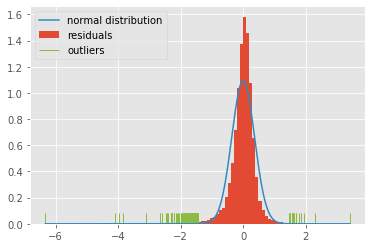

In [15]:
plt.hist(model_log.resid, 
    density=True,     # the histogram integrates to 1 
                      # (so it can be compared to the normal distribution)
    bins=100,         #  draw a histogram with 100 bins of equal width
    label="residuals" # label for legend
    )
# now plot the normal distribution for comparison
xx = np.linspace(model_log.resid.min(), model_log.resid.max(), num=10000)
plt.plot(xx, scipy.stats.norm.pdf(xx, loc=0.0, scale=np.sqrt(model_log.scale)),
    label="normal distribution")
sns.rugplot(model_log.resid[np.abs(model_log.resid)>4*np.sqrt(model_log.scale)],
            color="C5", # otherwise the color was the same as the histogram
            label="outliers")
plt.legend(loc="upper left")
;

Visually, it is not obvious that the residuals have improved. However, looking at the details paints a different picture. There are no fewer outliers, but many are now below the peak rather than above. Low outliers are easier to explain away as products of known external factors than high outliers; e.g. if the owner sells their house to a friend or relative, or the property is in particularly bad condition, then it could be sold at a severely reduced rate.

The residuals are also less skewed, and the tails of the distribution are less fat. This can be deduced from the `Skew` and `Kurtosis` metrics at the bottom of the summaries of the models (reproduced below for convenience):

In [16]:
model_lin.summary().tables[-1]

Omnibus:,16670.121,Durbin-Watson:,1.740
Prob(Omnibus):,0.000,Jarque-Bera (JB):,1483125.778
Skew:,2.504,Prob(JB):,0.00
Kurtosis:,40.825,Cond. No.,3.26e+04


In [17]:
model_log.summary().tables[-1]

Omnibus:,8475.447,Durbin-Watson:,1.741
Prob(Omnibus):,0.000,Jarque-Bera (JB):,120216.866
Skew:,-1.272,Prob(JB):,0.00
Kurtosis:,13.561,Cond. No.,186.


#### 5.2

Did the heteroscedasticity issue improve from Exercise 4?

**Answer.** One possible solution is shown below:

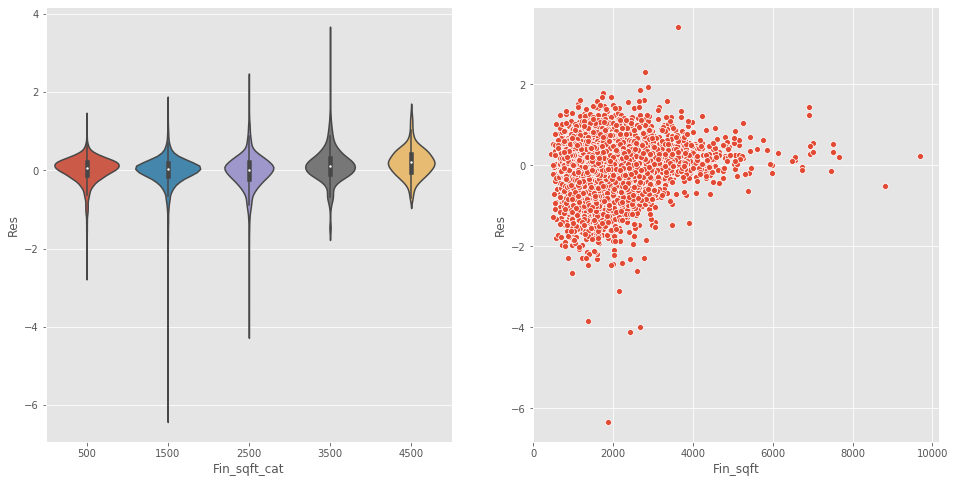

In [45]:
data_clean4=data_clean.copy()
bins = np.array([0, 1000, 2000, 3000, 4000])

data_clean4['Fin_sqft_cat']=bins[np.digitize(data_clean4['Fin_sqft'], bins)-1]+500

data_clean4['Res']=model_log.resid.values

fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(16,8))

sns.violinplot(x='Fin_sqft_cat', y='Res',data=data_clean4,
               positions=(500, 1500, 2500, 3500, 4500),
               widths=700,
               showextrema=True, ax=ax[0],alpha=0.02
               )
sns.scatterplot(x='Fin_sqft',y='Res',data=data_clean4,ax=ax[1])

We can also overlay the violin plot on top of the scatterplot as follows: 

''

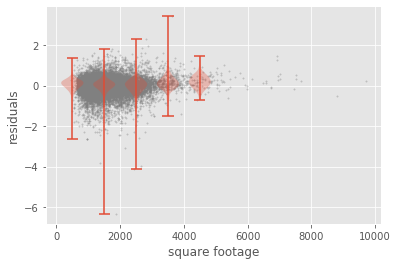

In [18]:
Fin_sqft = data_clean["Fin_sqft"]
plt.scatter(Fin_sqft, model_log.resid, s=2, alpha=0.3, color="grey")
bins = np.array([0, 1000, 2000, 3000, 4000])
sqft_bin = np.digitize(Fin_sqft, bins)
plt.violinplot([model_log.resid.values[sqft_bin == ibin] for ibin in range(1,len(bins)+1)],
               positions=[500, 1500, 2500, 3500, 4500],
               widths=700,
               showextrema=True,
               )
plt.xlabel("square footage")
plt.ylabel("residuals")
;

The distribution of the residuals as a function of square footage has stabilized, which supports the argument that the logarithmic scale is more natural to model property prices.

### Exercise 6: (5 min)

#### 6.1

How do we interpret the `Units` coefficient?

**Answer.** All else being equal, an additional unit decreases the log-price of the property by 0.35, which corresponds to a slightly less than 30% reduction in price (this is calculated as $1-e^{-0.35}$).

#### 6.2

What story does the `np.log(Fin_sqft)` coefficient tell us in this model?

(a) The price of a property is proportional to its square footage

(b) The price of a property goes down with square footage

(c) The price of a property goes up logarithmically with its square footage

(d) The price of a property goes up exponentially with its square footage

(e) The price of a property goes up with square footage, but there are diminishing returns

**Answer.** (e). The fitted coefficient is 0.87, which is positive but less than 1. In light of the fact that we have taken the logarithm of `Fin_sqft`, this implies *sublinear* growth; i.e. the price of a property goes up with square footage, but there are diminishing returns. Do you find this intuitive or surprising?

## Dealing with outliers (30 min)

Our analysis of residuals shows a number of outliers. As mentioned above, low outliers are not entirely unexpected; e.g. when people sell a property to friends or relatives, or if the property is in disrepair, the sale price could be significantly lower than expected by the model. Nonetheless, outliers can destabilize a model and significantly reduce their predictive ability despite only representing a fringe subset of the overall data.

### Question: (5 min)

What should an analyst do with outliers?

It is tempting to simply remove data points with large residuals; however, this viewpoint suffers from hindsight bias. Outliers with high residuals cannot be determined before the model is created, which means that they cannot be removed in advance.

Rather, the starting point should always be to inspect the initial raw data for any data points with unusually small or large values for certain features, and understand why they are different. If there is something clearly wrong with those data (like a misplaced decimal point), or if the reason for these small or large values can be effectively explained via an external factor that is not captured by the data itself, then this justifies removing them. Otherwise, it is best to keep these data points in mind throughout the modeling process, and deal with them during the modeling process itself.

### Exercise 7: (10 min)

Print the characteristics of the property with the greatest absolute residual (i.e. the worst outlier in the dataset). For this property, what is the fitted (predicted) and actual sale price?

Find all other sales of the same property in the dataset. Can you see an explanation for these extreme outliers?

**Answer:** The worst outlier is a house that our model predicted should sell for about \\$56,000, 
and instead was sold for \\$100. This same house was sold 8 months earlier for \\$189,000, which confirms that \\$100 is not the real market price. It could, for example, be a transaction between relatives.

In [19]:
iworst = np.abs(model_log.resid.values).argmax()
print("predicted sale price: ${:.0f}".format(
        np.exp(model_log.fittedvalues.iloc[iworst])))
data_clean.iloc[iworst] # select the worst row

predicted sale price: $56174


PropType                Residential
Taxkey                   3515031000
Address              1938 N 19TH ST
CondoProject                    NaN
District                         15
Nbhd                           3000
Style                      Colonial
Extwall            Aluminum / Vinyl
Stories                           2
Year_Built                     2010
Nr_of_rms                         0
Fin_sqft                       1860
Units                             1
Bdrms                             4
Fbath                             3
Hbath                             1
Lotsize                        5681
Sale_date       2010-10-01 00:00:00
Sale_price                      100
Name: 6484, dtype: object

In [20]:
# show all sales for this property
data_clean.loc[data_clean.Taxkey == data_clean.iloc[iworst].Taxkey,["Sale_date","Sale_price"]]

,Sale_date,Sale_price
4990,2010-02-01,189000
6484,2010-10-01,100


The scatter plot below shows the residuals vs. the sale price for all properties in the data. The cluster in the bottom left corner shows properties that sold at a much lower price than expected by the model, which can be explained as transactions below market rate between friends or relatives. This would justify removing all transactions below about $2,000 from the dataset before re-running the analysis:

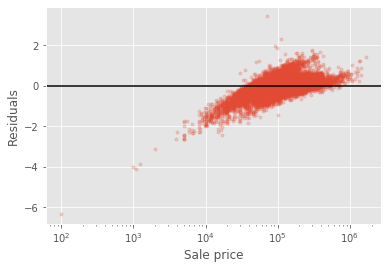

In [21]:
plt.semilogx(data_clean["Sale_price"], model_log.resid, ".", alpha=0.2)
plt.ylabel("Residuals")
plt.xlabel("Sale price")
plt.axhline(0, color="black")

We can quantify the effect of these outliers by removing them and re-running the regression, and seeing how the fitted coefficients change.

### Exercise 8: (15 min)

#### 8.1

Re-run the same model one a reduced dataset which removes all outliers with absolute residuals greater than 1.5.

1. What percentage of the data is removed?
2. What is the value of the fitted `Units` coefficient before and after removing outliers?
3. Is the difference significant?
4. What coefficients move by more than two standard errors after removing outliers?

**Answer.** One possible solution is given below:

In [22]:
# Removing outliers with residuals greater than 1.5
# results in a noticably different `Units` coefficient,
# even though only 0.5% of observations are removed
outliers = np.abs(model_log.resid) < 1.5
data_noout = data_clean.loc[outliers, :]
# refit a model with the reduced data
model_noout = smf.ols(formula = "np.log(Sale_price) ~ District + Units"
                              "+ np.log(Fin_sqft)", 
                      data = data_noout).fit()
# inspect the `Units` coefficient
print("{:.2f}% of data removed".format((1-data_noout.size/data_clean.size)*100))
print("`Units` coefficient in full model:          {:.3f}".format(model_log.params["Units"]))
print("`Units` coefficient with excluded outliers: {:.3f}".format(model_noout.params["Units"]))

0.56% of data removed
`Units` coefficient in full model:          -0.352
`Units` coefficient with excluded outliers: -0.382


In [23]:
# how many SE's does the coefficient move by:
move = (model_log.params-model_noout.params)/model_log.bse
move[np.abs(move)>2] # coefficients that move by more than 2 SE's

District[T.15]   -2.044336
District[T.6]    -3.645634
Units             4.660283
dtype: float64

This procedure only removes around 0.5% of the data, but the `Units` coefficient changes significantly from $-0.352$ to $-0.382$. This may not seem like much, but the standard error of this coefficient was 0.006, so the estimate has shifted by almost *five standard errors*, which is indeed a significant change.

#### 8.2

Check whether particularly small or large properties also tend to result in outliers.

**Answer.** No. As one can see from the residuals plot below, there isn't a notable cluster of properties anywhere far away from the zero line:

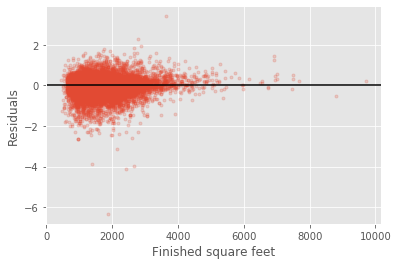

In [24]:
plt.plot(data_clean["Fin_sqft"], model_log.resid, ".", alpha=0.2)
plt.ylabel("Residuals")
plt.xlabel("Finished square feet")
plt.axhline(0, color="black")

The bulge in the center of the scatterplot of residuals above may look like heteroscedasticity. However, this effect can appear simply because a lot of properties are between 1,000 to 2,000 square feet, which causes the scatter plot to “bulge out” in the middle. You can construct a violin plot of the same data to dispel any doubts about this claim.

## Conclusions (2 min)

We used linear regression to predict property sale price in Milwaukee, Wisconsin, and illustrated some potential issues with linear regression. When some of the assumptions of linear regression are severly violated, like normality of the residuals and homoescedasticity, the fitted model can be destabilized. As an example, we saw how a small number of outliers can shift a fitted coefficient by several standard errors.

## Takeaways (5 min)

In this case we have learned:
    
1. How to recognize heteroscedasticity in the residuals and why it is important to treat it. 
2. How transforming the outcome variable can be helpful to reduce skewness and alleviate some of the heteroscedasticity present in the residuals.
3. How to properly treat outliers in the residuals. We recognized that it is always better to understand the meaning behind some of the outliers in order to safely discard them from our models. In this case, a logarithmic transformation of the sale price alleviated many of the issues in the model. However, other datasets may invite different transformations. You should combine intuition and experimentation to find the right transformation to use.
5. How to conduct residual analysis when using linear regression in your projects. As we have seen, these will help you to improve not only the quality of your models, but also your intuition and expertise when conducting future data analyses at work.